# Lab 8 - Denoising Autoencoder

**Tasks**

1. Develop denoising autoencoder, which will remove noise from the images from CIFAR10 dataset. Select the type of noise you will remove from the image.

2. Develop a function that takes as input noised image from CIFAR10 dataset and returns reconstructed one, using the developed model.

In [1]:
import numpy as np

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test  = np.reshape(x_test,  (len(x_test),  32, 32, 3))

170500096/170498071 [==============================] - 4s 0us/step


**Noise definition**

Let's denoise from Normal distribution $\mu = 1$ and $\sigma=0.15 * x, x \sim U(0, 1)$ in ***overlay*** mode

In [12]:
import random
import numpy as np

def add_noise(img):
    noise = np.random.normal(1.0, 0.2, img.shape)
    img_copy = noise * img
    np.clip(img_copy, 0., 1.)
    return img_copy

In [13]:
x_train_with_noise = add_noise(x_train)
x_test_with_noise = add_noise(x_test)

**Transform visualized**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


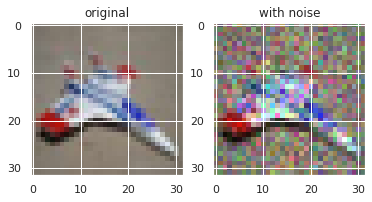

In [14]:
def draw_original_noise_pred(img, img_with_noise=None, img_pred=None):
    if img_with_noise is not None and img_pred is not None:
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(img)
        ax[0].set_title('original')
        ax[1].imshow(img_with_noise)
        ax[1].set_title('with noise')
        ax[2].imshow(img_pred)
        ax[2].set_title('denoised')
        return
    if img_with_noise is not None:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img)
        ax[0].set_title('original')
        ax[1].imshow(img_with_noise)
        ax[1].set_title('with noise')
    plt.show()

idx = 30
draw_original_noise_pred(x_train[idx], x_train_with_noise[idx])

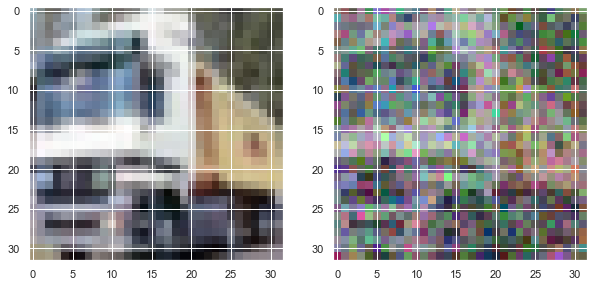

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=add_noise,
)

from tensorflow.keras.preprocessing import image

def show_after_transform(img):
    images = [img]
    img_arr = image.img_to_array(img)
    img_arr = img_arr.reshape((1,) + img_arr.shape)
    for batch in datagen.flow(img_arr, batch_size=1):
        images.append( image.array_to_img(batch[0]) )
        if len(images) >= 4:
            break

    import matplotlib.pyplot as plt
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(images[0])
    ax[1].imshow(images[1])
    plt.show()
show_after_transform(x_train[1])

In [7]:
def create_autoencoder(input_img, outer_dim = 32, intermediate_dim = 64, embedding_dim = 128):
    #encoder
    conv1 = Conv2D(outer_dim, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(intermediate_dim, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(embedding_dim, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(embedding_dim, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(intermediate_dim, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(conv5)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [15]:
input_img = Input(shape=(32, 32, 3))

model = Model(input_img, create_autoencoder(input_img))
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy'
)

history = model.fit(
    x_train_with_noise, x_train,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/20
196/196 [==============================] - 7s 32ms/step - loss: 0.6138 - val_loss: 0.5704
Epoch 2/20
196/196 [==============================] - 6s 30ms/step - loss: 0.5656 - val_loss: 0.5637
Epoch 3/20
196/196 [==============================] - 6s 30ms/step - loss: 0.5627 - val_loss: 0.5619
Epoch 4/20
196/196 [==============================] - 6s 30ms/step - loss: 0.5624 - val_loss: 0.5628
Epoch 5/20
196/196 [==============================] - 6s 30ms/step - loss: 0.5603 - val_loss: 0.5605
Epoch 6/20
196/196 [==============================] - 6s 31ms/step - loss: 0.5593 - val_loss: 0.5610
Epoch 7/20
196/196 [==============================] - 6s 31ms/step - loss: 0.5582 - val_loss: 0.5597
Epoch 8/20
196/196 [==============================] - 6s 31ms/step - loss: 0.5579 - val_loss: 0.5605
Epoch 9/20
196/196 [==============================] - 6s 31ms/step - loss: 0.5574 - val_loss: 0.5585
Epoch 10/20
196/196 [==============================] - 6s 31ms/step - loss: 0.5570 - val_lo

In [16]:
pred = model.predict(x_test_with_noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


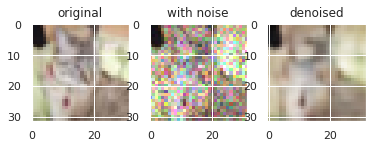

In [17]:
idx = 8
draw_original_noise_pred(x_test[idx], x_test_with_noise[idx], pred[idx])

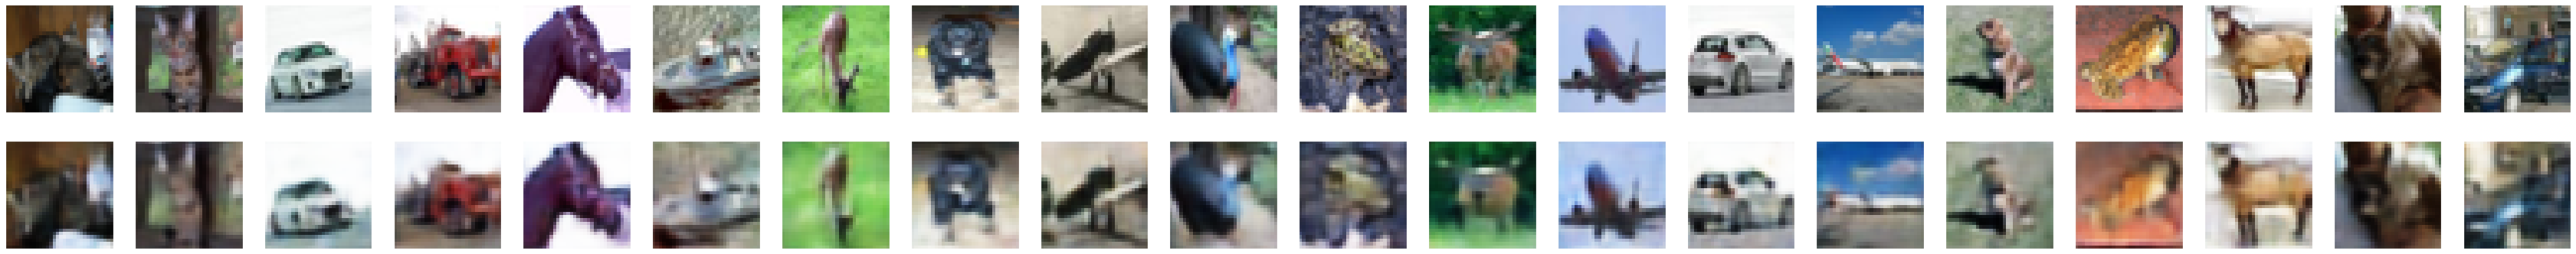

In [19]:
def plot_images(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(3*n, 3*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

rng = np.random.default_rng()
random_idxs = rng.choice(len(pred), size=20, replace=False)

plot_images(x_test[random_idxs], pred[random_idxs])

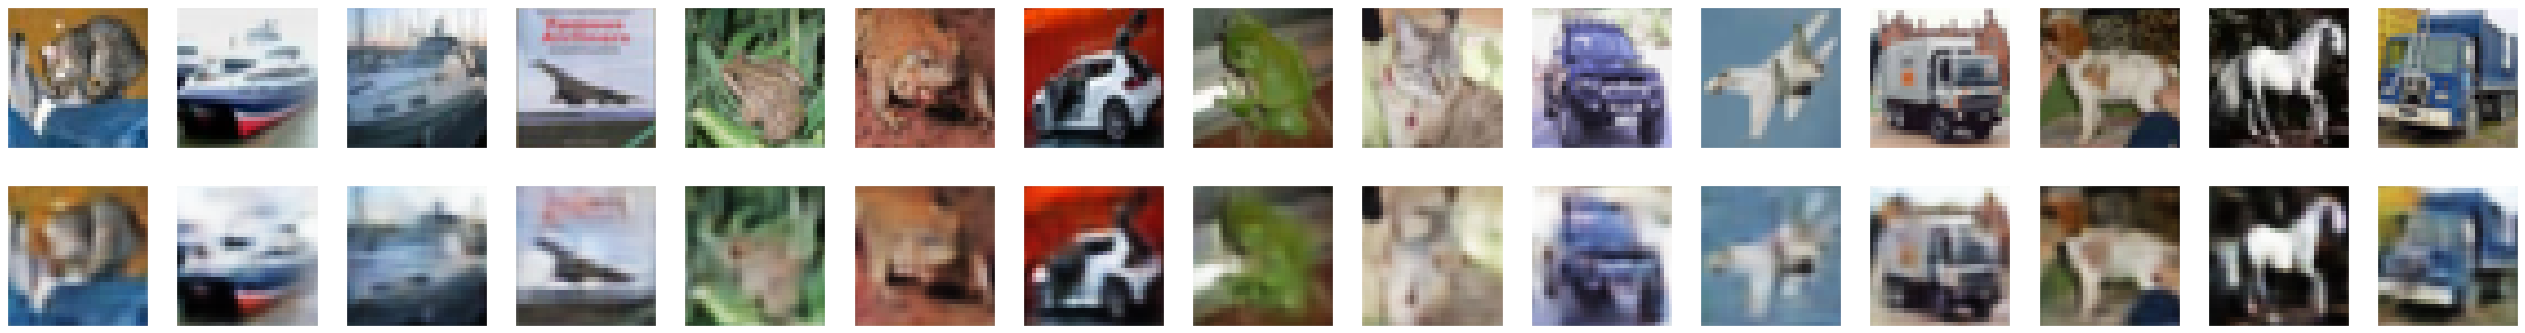

In [21]:
fist_slice = np.array([i for i in range(15)])
plot_images(x_test[fist_slice], pred[fist_slice])